<a href="https://colab.research.google.com/github/chunyulin/test/blob/master/TF_0_hello.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
###
###  First, check your TF version and the hardware enviorment
###
import tensorflow as tf
#import tensorflow.compat.v1 as tf

from tensorflow.python.client import device_lib

print ("Using Tensorflow: ", tf.__version__)
print ( device_lib.list_local_devices() )


Using Tensorflow:  2.2.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3813748545573676834
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11445488560542056787
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 381849551313152566
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1963956400254218049
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
### First, check GPU status if you have a GPU 
!nvidia-smi

Tue Jun  9 08:38:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    57W / 149W |    130MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
###
### Variables, Constant, Placeholders
###
tf.reset_default_graph()

## create a variable of rank-3 zero tensor  
# GraphKeys can be such as:
#   GLOBAL_VARIABLES
#   LOCAL_VARIABLES
#   TRAINABLE_VARIABLES, or control by "trainable=False"
#
var = tf.get_variable("var", shape=[2, 3], dtype=tf.float32, 
         initializer=tf.zeros_initializer, collections=[tf.GraphKeys.LOCAL_VARIABLES])

with tf.variable_scope("ABC"):
    a = tf.add(3, 5)
    a = tf.cast(a, tf.float32) 

sess = tf.Session()
sess.run(tf.global_variables_initializer())
print (sess.run(a) )
print (sess.run( tf.sin(a) ))

sess.run(tf.local_variables_initializer())
var = (var + 1.0 )*5
print (sess.run(var))



sess.close()


AttributeError: ignored

### From TF1 -> TF2
TF 1.x relies on global namespaces. Tf.Variable() will be put into default graph and will stay there. When loosing track, it could only be recovered when the name is known. -- A bad software-engineering practice
* The v1 syntax not work anymore. No more global namespaces and mechanisms to find variables.
* Use Keras layers, or keep track of the variables yourself
* Garbage Collector takes care of lost variables
* variable_scope and get_variable will be removed
* naming will be controlled via tf.name_scope + tf.Variable

### Eager Execution
Eager execution evaluates operations immediately instead building graphs.
That means operations return concrete values instead of constructing a computational graph to run
later
Introduced with TensorFlow 1.8
Default mode in Version 2



In [0]:
## tf.Tensor object references concrete value TF2
x = [[2.]]
m = tf.matmul(x, x)
print("{}".format(m))

## Another example:
a = tf.constant([[1, 2], [3, 4]])
print(a)
b = a + tf.constant([1])   # broadcasting
print(b)
print(a*b)

[[4.]]
tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [0]:
## Also, you can interact with numpy
import numpy as np
c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [0]:
##
## Now start a MNIST example:
##

## 1) Model building
class MNISTModel(tf.keras.Model):
  def __init__(self):
    super(MNISTModel, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(16, (3,3), padding="same", activation='relu')
    self.conv2 = tf.keras.layers.Conv2D(16, (3,3), padding="same", activation='relu')
    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(units=(10), activation='softmax')
  def call(self, input):
    result = self.conv1(input)
    result = self.conv2(result)
    result = self.flatten(result)
    result = self.dense(result)
    return result

model = MNISTModel()
model._set_inputs(tf.keras.Input(shape=(28,28,1,)))

In [0]:
## 2) Preparation of dataset

(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()
print(mnist_images.shape)

dataset = tf.data.Dataset.from_tensor_slices((tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32), tf.cast(mnist_labels, tf.int64)))
dataset = dataset.shuffle(100).batch(32)
print(dataset)

(60000, 28, 28)
<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


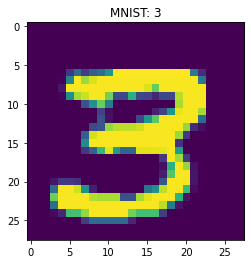

In [0]:
## 2a) Visualize dataset, Data cleaning, Data veracity checking ...

import matplotlib.pyplot as plt
ID=111
plt.imshow(mnist_images[ID])
plt.title("MNIST: %d" % mnist_labels[ID])
plt.show()

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_history = []
for (batch, (images, labels)) in enumerate(dataset.take(400)):
  if batch % 100 == 0:   
    print('Batch %d'%batch, end='\n')
  with tf.GradientTape() as tape:
    logits = model(images)
    loss_value = tf.keras.losses.sparse_categorical_crossentropy(labels, logits)
  
  loss_history.append(np.mean(loss_value))
  grads = tape.gradient(loss_value, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables)
)
  
print("Done.")

Batch 0
Batch 100
Batch 200
Batch 300
Done.


In [0]:
for images,labels in dataset.take(5):
  print("Predict: ", model(images).numpy().argmax())
  print( plt.imshow(images.numpy().reshape(28,28*5)))
tf.saved_model.save(model, "model/mnist.model")   ##  It seems TF can create an folder if not existed.
!ls

Logits:  44


ValueError: ignored

In [0]:
!ls model

mnist.model


[0.047212742,
 0.14273638,
 0.011704192,
 0.06077718,
 0.020572633,
 0.042891786,
 0.0012368283,
 0.019683376,
 0.006095957,
 0.16218373,
 0.14090282,
 0.073420025,
 0.029844478,
 0.25074214,
 0.032874133,
 0.04691821,
 0.03177294,
 0.14646508,
 0.04181207,
 0.019091481,
 0.003219672,
 0.021124315,
 0.07171784,
 0.005102005,
 0.023281697,
 0.006045812,
 0.05210076,
 0.014543668,
 0.009718967,
 0.105733156,
 0.003953214,
 0.032255244,
 0.05587341,
 0.08300457,
 0.005664858,
 0.06873157,
 0.08113486,
 0.030028332,
 0.0083517255,
 0.07398383,
 0.1460861,
 0.0075782705,
 0.0651124,
 0.002162896,
 0.008529645,
 0.009114361,
 0.0287327,
 0.12776594,
 0.0029483943,
 0.0012304203,
 0.0027728062,
 0.20643046,
 0.0070868987,
 0.023761632,
 0.05054181,
 0.0066503556,
 0.017123237,
 0.0074641574,
 0.016045144,
 0.005650207,
 0.005617462,
 0.0060430104,
 0.005697422,
 0.057608917,
 0.026058132,
 0.018247062,
 0.020370238,
 0.014737766,
 0.011616894,
 0.026003351,
 0.0030857585,
 0.004742988,
 0.051

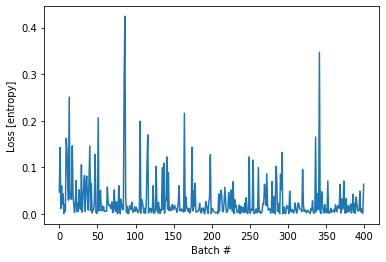

In [0]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')
loss_history

In [0]:
### For advanced feature, we can specify which device to be used. 
### This is only for futher development of distributed training.
###
### We can program TF just like a complex MPI program with C.
###  
import tensorflow as tf
from tensorflow.python.client import device_lib

# Creates a graph.
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2,3],name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3,2],name='b')
    c = tf.matmul(a, b)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print (sess.run(c) )

[[22. 28.]
 [49. 64.]]


In [0]:
###
###  Build a simple a perceptron model -- logistic regression (sigmoid)
###
import tensorflow as tf
tf.reset_default_graph()

IN_DIM = 3
OUT_DIM = 1
x = tf.placeholder(tf.float32, [None, IN_DIM])
y = tf.placeholder(tf.float32, [None, OUT_DIM])

W  = tf.Variable(tf.zeros([IN_DIM, OUT_DIM]), name="W")
b  = tf.Variable(tf.zeros([OUT_DIM]),         name="b")

output  = tf.sigmoid(tf.matmul(x, W) + b)

xdata = [  [1.,2.,3.],
           [1.,2.,3.]   ]  ## input data with batch size = 2
#xdata2 = tf.ones_like(xdata)



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    out = sess.run([output], feed_dict={x: xdata}  )   #  2 outputs 
    print (out)

[array([[0.5],
       [0.5]], dtype=float32)]
